In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
cd /content/drive/MyDrive/Deep_Learning_Project/SubLSTM_PaperCode_Codemixed_Data1

/content/drive/MyDrive/Deep_Learning_Project/SubLSTM_PaperCode_Codemixed_Data1


In [11]:
import numpy as np
import h5py
import pickle
import tensorflow as tf
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import np_utils
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [12]:
import re
def token(sentence, remove_vowels=False, remove_repeat=False, minchars=2):
    tokens = []
#   for t in re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\w]+",sentence.lower()):
    for t in re.findall("[a-zA-Z]+",sentence.lower()):

        if len(t)>=minchars:
            if remove_vowels:
                t=removeVovels(t)
            if remove_repeat:
                t=removeRepeat(t)
            tokens.append(t)
    return tokens

VOWELS = ['a', 'e', 'i', 'o', 'u']

def removeRepeat(string):
    return re.sub(r'(.)\1+', r'\1\1', string)     

def removeVovels(string):
    return ''.join([l for l in string.lower() if l not in VOWELS])

# if __name__ == '__main__':
#     pass

def normalize_matrix(matrix):
    pass

In [13]:
SEPERATOR = '\t'
DATA_COLUMN = 1
LABEL_COLUMN = 3
LABELS = ['0','1','2'] # 0 -> Negative, 1-> Neutral, 2-> Positive
mapping_char2num = {}
mapping_num2char = {}
MAXLEN = 200

#LSTM Model Parameters
#Embedding
MAX_FEATURES = 0
embedding_size = 128
# Convolution
filter_length = 3
nb_filter = 128
pool_length = 3
# LSTM
lstm_output_size = 128
# Training
batch_size = 128
number_of_epochs = 50
numclasses = 3
test_size = 0.2

In [14]:
def parse(seperator,datacol,labelcol,labels):
    """
    Purpose -> Data I/O
    Input   -> Data file containing sentences and labels along with the global variables
    Output  -> Sentences cleaned up in list of lists format along with the labels as a numpy array
    """
    #Reads the files and splits data into individual lines
    f=open('Codemixed.txt','r', encoding='utf-8')
    lines = f.read()
    lines = lines.lower().split('\n')[:-1]

    X_train = []
    Y_train = []
    
    #Processes individual lines
    for line in lines:
        # Seperator for the current dataset. Currently '\t'. 
        line = line.split(seperator)
        #Token is the function which implements basic preprocessing as mentioned in our paper
        tokenized_lines = token(line[datacol])
    
        #Creates character lists
        char_list = []
        for words in tokenized_lines:
            for char in words:
                char_list.append(char)
            char_list.append(' ')
        #print(char_list) - Debugs the character list created
        X_train.append(char_list)
    
        #Appends labels
        if line[labelcol] == labels[0]:
            Y_train.append(0)
        if line[labelcol] == labels[1]:
            Y_train.append(1)
        if line[labelcol] == labels[2]:
            Y_train.append(2)
    
    #Converts Y_train to a numpy array	
    Y_train = np.asarray(Y_train)
    assert(len(X_train) == Y_train.shape[0])

    return [X_train,Y_train]

In [15]:
def convert_char2num(mapping_n2c,mapping_c2n,trainwords,maxlen):
    """
    Purpose -> Convert characters to integers, a unique value for every character
    Input   -> Training data (In list of lists format) along with global variables
    Output  -> Converted training data along with global variables
    """
    allchars = []
    errors = 0

    #Creates a list of all characters present in the dataset
    for line in trainwords:
        try:
            allchars = set(allchars+line)
            allchars = list(allchars)
        except:
            errors += 1

    #print(errors) #Debugging
    #print(allchars) #Debugging 

    #Creates character dictionaries for the characters
    charno = 0
    for char in allchars:
        mapping_char2num[char] = charno
        mapping_num2char[charno] = char
        charno += 1

    assert(len(allchars)==charno) #Checks

    #Converts the data from characters to numbers using dictionaries 
    X_train = []
    for line in trainwords:
        char_list=[]
        for letter in line:
            char_list.append(mapping_char2num[letter])
        #print(no) -- Debugs the number mappings
        X_train.append(char_list)
    print(mapping_char2num)
    print(mapping_num2char)
    #Pads the X_train to get a uniform vector
    #TODO: Automate the selection instead of manual input
    X_train = sequence.pad_sequences(X_train[:], maxlen=maxlen)
    return [X_train,mapping_num2char,mapping_char2num,charno]

In [16]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [17]:
# def RNN(X_train,y_train,args):
#     """
#     Purpose -> Define and train the proposed LSTM network
#     Input   -> Data, Labels and model hyperparameters
#     Output  -> Trained LSTM network
#     """
#     #Sets the model hyperparameters
#     #Embedding hyperparameters
#     max_features = args[0]
#     maxlen = args[1]
#     embedding_size = args[2]
#     # Convolution hyperparameters
#     filter_length = args[3]
#     nb_filter = args[4]
#     pool_length = args[5]
#     # LSTM hyperparameters
#     lstm_output_size = args[6]
#     # Training hyperparameters
#     batch_size = args[7]
#     nb_epoch = args[8]
#     numclasses = args[9]
#     test_size = args[10] 

#     #Format conversion for y_train for compatibility with Keras
#     y_train = np_utils.to_categorical(y_train, numclasses) 
#     #Train & Validation data splitting
#     X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
    
#     #Build the sequential model
#     # Model Architecture is:
#     # Input -> Embedding -> Conv1D+Maxpool1D -> LSTM -> LSTM -> FC-1 -> Softmaxloss
#     print('Build model...')
#     model = Sequential()
#     model.add(Embedding(max_features, embedding_size, input_length=maxlen))
#     # model.add(Convolution1D(nb_filter=nb_filter,
#     #filter_length=filter_length,
#     #activation='relu',
#     #subsample_length=1))
#     # model.add(MaxPooling1D(pool_length=pool_length))
#     model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=True))
#     model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=False))
#     model.add(Dense(numclasses))
#     model.add(Activation('softmax'))

#     # Optimizer is Adamax along with categorical crossentropy loss
#     model.compile(loss='categorical_crossentropy',
#                 optimizer='adamax',
#                 metrics=['accuracy'])


#     print('Train...')
#     #Trains model for 50 epochs with shuffling after every epoch for training data and validates on validation data
#     model.fit(X_train, y_train, 
#               batch_size=batch_size, 
#               shuffle=True, 
#               nb_epoch=nb_epoch,
#               validation_data=(X_valid, y_valid))
#     return model

In [18]:
if __name__ == '__main__':
    """
    Master function
    """
    print('Starting RNN Engine...\nModel: Char-level LSTM.\nParsing data files...')
    out = parse(SEPERATOR,DATA_COLUMN,LABEL_COLUMN,LABELS)
    X_train = out[0]
    y_train = out[1]
    print('Parsing complete!')

    print('Creating character dictionaries and format conversion in progess...')


Starting RNN Engine...
Model: Char-level LSTM.
Parsing data files...
Parsing complete!
Creating character dictionaries and format conversion in progess...


In [19]:
out = convert_char2num(mapping_num2char,mapping_char2num,X_train,MAXLEN)
mapping_num2char = out[1]
mapping_char2num = out[2]
MAX_FEATURES = out[3]
X_train = np.asarray(out[0])
y_train = np.asarray(y_train).flatten()
print('Complete!')

print('Splitting data into train and test...')
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)



{'t': 0, 'm': 1, 'g': 2, 'l': 3, 'n': 4, 'a': 5, 'w': 6, 'p': 7, 'e': 8, ' ': 9, 'q': 10, 'h': 11, 'r': 12, 'i': 13, 'y': 14, 'v': 15, 'z': 16, 'b': 17, 'k': 18, 's': 19, 'd': 20, 'f': 21, 'c': 22, 'j': 23, 'x': 24, 'o': 25, 'u': 26}
{0: 't', 1: 'm', 2: 'g', 3: 'l', 4: 'n', 5: 'a', 6: 'w', 7: 'p', 8: 'e', 9: ' ', 10: 'q', 11: 'h', 12: 'r', 13: 'i', 14: 'y', 15: 'v', 16: 'z', 17: 'b', 18: 'k', 19: 's', 20: 'd', 21: 'f', 22: 'c', 23: 'j', 24: 'x', 25: 'o', 26: 'u'}
Complete!
Splitting data into train and test...
X_train shape: (3103, 200)
X_test shape: (776, 200)


In [20]:
y_train = np_utils.to_categorical(y_train ,numclasses) 

In [21]:

#Train & Validation data splitting
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size)

In [22]:
# sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
# embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
# # Getting our LSTM outputs
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])

# context_vector, attention_weights = Attention(10)(lstm, state_h)
# dense1 = Dense(20, activation="relu")(context_vector)
# dropout = Dropout(0.4)(dense1)
# output = Dense(1, activation="sigmoid")(dropout)

# model = keras.Model(inputs=sequence_input, outputs=output)


In [23]:
RNN_CELL_SIZE = 128
sequence_input = Input(shape=(MAXLEN,), dtype="int32")
embedded_sequences = Embedding(27, embedding_size, input_length=MAXLEN)(sequence_input)
# conv1 =  Convolution1D(filters=128,kernel_size=3,
#                             padding='valid',
#                             activation='relu',
#                             dilation_rate=1)(embedded_sequences)
# conv2 = Convolution1D(filters=128,kernel_size=3,
#                             padding='valid',
#                             activation='relu',
#                             dilation_rate=1)(conv1)
# pool = GlobalMaxPool1D()(conv2)

lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(32, activation="relu")(context_vector)
dropout = Dropout(0.4)(dense1)
output = Dense(3, activation="softmax")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [24]:
# model = Sequential()
# model.add(Embedding(27, embedding_size, input_length=MAXLEN))

# model.add(Convolution1D(filters=128,kernel_size=3,
#                             padding='valid',
#                             activation='relu',
#                             dilation_rate=1))
# model.add(Convolution1D(filters=128,kernel_size=3,
#                             padding='valid',
#                             activation='relu',
#                             dilation_rate=1))
# model.add(MaxPooling1D(pool_size=3))
# model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
# # model.add(Dropout=(0.2))
# model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)))
# # model.add(Dropout=(0.2))
# model.add(Dense(3))
# model.add(Activation('softmax'))
# print(model.summary())

In [25]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 128)     3456        input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 200, 256)     263168      embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 200, 256), ( 394240      bi_lstm_0[0][0]                  
______________________________________________________________________________________________

In [26]:
model.compile(loss='categorical_crossentropy',
        optimizer='adamax',
        metrics=['accuracy'])

In [27]:
# opt=keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy',
        optimizer='adamax',
        metrics=['accuracy'])
print('Train...')
#Trains model for 50 epochs with shuffling after every epoch for training data and validates on validation data
history = model.fit(X_train, y_train, 
          batch_size=batch_size, 
          shuffle=True, 
          epochs=20,
          validation_data=(X_valid, y_valid))

Train...
Epoch 1/20
20/20 [==============================] - 76s 3s/step - loss: 1.0233 - accuracy: 0.4542 - val_loss: 0.9656 - val_accuracy: 0.5056
Epoch 2/20
20/20 [==============================] - 67s 3s/step - loss: 0.9938 - accuracy: 0.5078 - val_loss: 0.9579 - val_accuracy: 0.5169
Epoch 3/20
20/20 [==============================] - 68s 3s/step - loss: 0.9917 - accuracy: 0.5106 - val_loss: 0.9481 - val_accuracy: 0.5298
Epoch 4/20
20/20 [==============================] - 69s 3s/step - loss: 0.9805 - accuracy: 0.5108 - val_loss: 0.9437 - val_accuracy: 0.5346
Epoch 5/20
20/20 [==============================] - 74s 4s/step - loss: 0.9694 - accuracy: 0.5234 - val_loss: 0.9321 - val_accuracy: 0.5411
Epoch 6/20
20/20 [==============================] - 68s 3s/step - loss: 0.9634 - accuracy: 0.5228 - val_loss: 0.9306 - val_accuracy: 0.5395
Epoch 7/20
20/20 [==============================] - 69s 3s/step - loss: 0.9517 - accuracy: 0.5084 - val_loss: 0.9237 - val_accuracy: 0.5491
Epoch 8/20


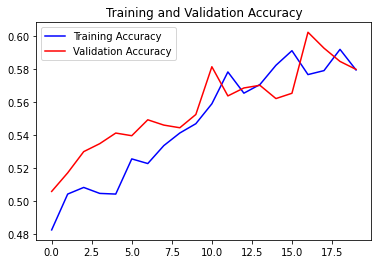

<Figure size 432x288 with 0 Axes>

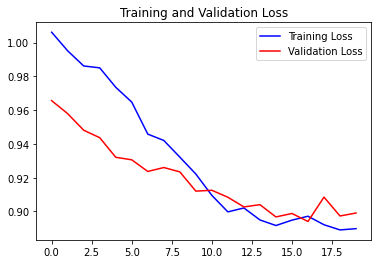

In [29]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [30]:
y_tst = y_test
y_test = np_utils.to_categorical(y_test, numclasses)
# Evaluate the accuracies
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
y_tst

7/7 [==============================] - 6s 827ms/step - loss: 0.8790 - accuracy: 0.5992
Test score: 0.8789722919464111
Test accuracy: 0.5992268323898315


array([1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0,
       1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1,
       0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0,
       1, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1,
       2, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 2,
       2, 2, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2,
       1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
       0, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2,

In [31]:
y_pred=model.predict(X_test)
y_pred

array([[0.1571395 , 0.60204303, 0.2408175 ],
       [0.25759652, 0.47142056, 0.27098295],
       [0.10074608, 0.6359725 , 0.2632814 ],
       ...,
       [0.25542223, 0.43776554, 0.30681217],
       [0.15206754, 0.3575761 , 0.49035645],
       [0.14947978, 0.56699467, 0.28352556]], dtype=float32)

In [34]:
y_pred1=np.argmax(y_pred,axis=1)
y_pred1

array([1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 2, 1,
       1, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1,
       2, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2,
       2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1,
       2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
# y_pred = model.predict(X_test)
prediction = (y_pred > 0.5)
prediction

array([[False,  True, False],
       [False, False, False],
       [False,  True, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False,  True, False]])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.01      0.02       116
           1       0.71      0.58      0.64       395
           2       0.71      0.27      0.39       265

   micro avg       0.71      0.39      0.50       776
   macro avg       0.80      0.29      0.35       776
weighted avg       0.75      0.39      0.46       776
 samples avg       0.39      0.39      0.39       776



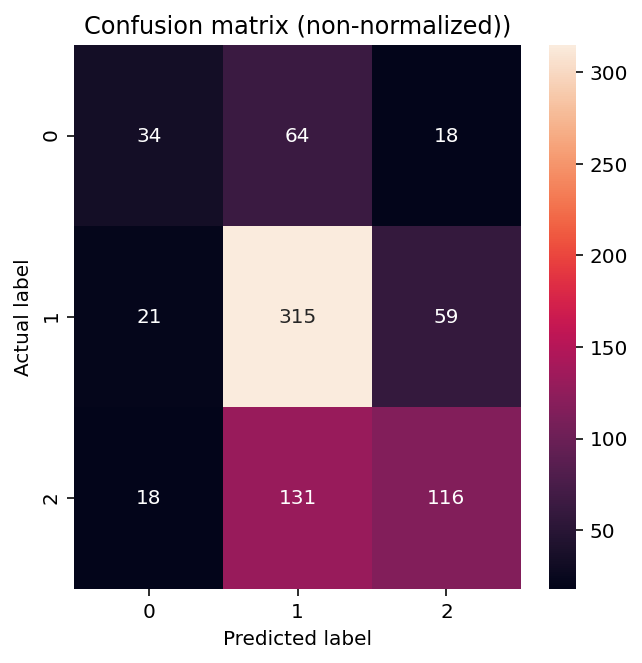

In [36]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, prediction)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_tst, y_pred1)